# SE-Resnet50 avec PyTorch

Dans un premier temps, nous allons transformer et entraîner les données à l'aide de package PyTorch pour pouvoir entraîner le modèle SE-Resnet50 pré-entraîné sur les photos d'ImageNet.


## Charger les packages


In [0]:
import torch
import torchvision
from platform import python_version
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Check the pre-requirements
torch.__version__

'1.3.1'

In [3]:
# Check the pre-requirements
print(python_version())

3.6.9


In [4]:
# Check the pre-requirements
torchvision.__version__

'0.4.2'

In [5]:
# CUDA testing
torch.cuda.is_available()

True

## Pointer vers gdrive

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks

/content/gdrive/My Drive/Colab Notebooks


## Préparer les données avec PyTorch

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.2,0.2)),# width_shift_range =0.2
        #height_shift_range = 0.2
        # rotation_range=20
        transforms.RandomHorizontalFlip(),# horizontal_flip=True
        transforms.ColorJitter(brightness=[0.5,1.2]),# brightness_range=[0.5,1.2]
        transforms.ToTensor(),# !!! Before normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

data_dir = 'redim_download'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100, # Changed 32 -> 100
                                             shuffle=True, num_workers=0) 
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
dataset_sizes

{'train': 12000, 'valid': 2880}

In [10]:
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

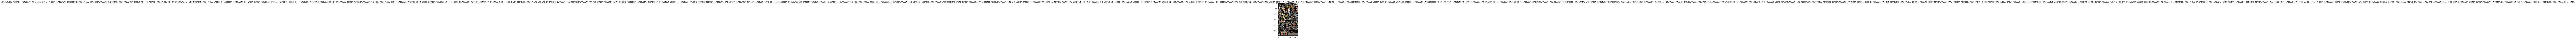

In [8]:
# Visualizer quelques photos
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entraîner le modèle

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Add empty lists to stock the values
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Upgrade the loss and accuracy values:
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, valid_loss, valid_acc

## Visualizer les prédictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loader le modèle SE-ResNet50 pré-entraîné sur imagenet 



In [13]:
import torch.hub
SE_resnet50 = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,)

Downloading: "https://github.com/moskomule/senet.pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/moskomule/senet.pytorch/releases/download/archive/seresnet50-60a8950a85b2b.pkl" to /root/.cache/torch/checkpoints/seresnet50-60a8950a85b2b.pkl
100%|██████████| 107M/107M [00:02<00:00, 40.6MB/s]


In [0]:
SE_resnet50.eval()

## Finetuning

In [0]:
num_ftrs = SE_resnet50.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
SE_resnet50.fc = nn.Linear(num_ftrs, len(class_names))

# GPU set up
SE_resnet50 = SE_resnet50.to(device)

# Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(SE_resnet50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Entraînement et évaluation

In [0]:
SE_resnet50, train_loss, train_acc, valid_loss, valid_acc = train_model(SE_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------


In [0]:
def convert_acc(acc):
    """ Converting list of tensors to list of values to be used to plot the learning curves """
    new_array = []
    for elt in range(len(acc)):
        acc_new = acc[elt].item()
        new_array.append(acc_new) 
    return new_array

In [0]:
train_acc = convert_acc(train_acc)
valid_acc = convert_acc(valid_acc)

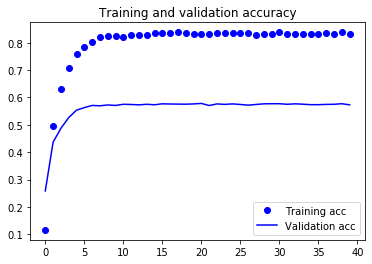

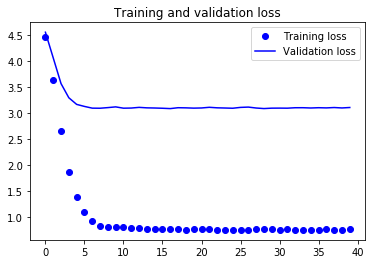

In [17]:
#Plot the training & validation loss & accuracy
import matplotlib.pyplot as plt

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, valid_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

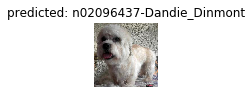

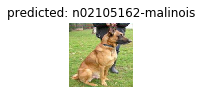

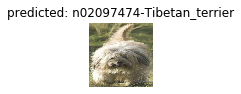

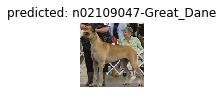

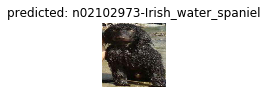

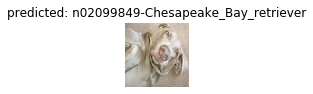

In [18]:
visualize_model(SE_resnet50)

In [0]:
# Save the model
PATH = './SE_resnet50.pth'
torch.save(SE_resnet50.state_dict(), PATH)

## Evaluation sur les données test


In [0]:
test_data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

In [37]:
image_datasets = datasets.ImageFolder('redim_download/test',
                                          test_data_transforms['test'])

RuntimeError: ignored

In [0]:
testloader = torch.utils.data.DataLoader(image_datasets, batch_size=100,
                                             shuffle=False, num_workers=0) 

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
# How the model perform on the whole dataset ?
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # Convert to CUDA tesnsor
        images, labels = data[0].to(device), data[1].to(device) 
        outputs = SE_resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 0 %


# Resnet 50

## Loader le modèle ResNet50 pré-entraîné sur imagenet 



In [28]:
import torch
resnet50 = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [0]:
resnet50.eval()

In [0]:
num_ftrs = resnet50.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resnet50.fc = nn.Linear(num_ftrs, len(class_names))

# GPU set up
resnet50 = resnet50.to(device)

# Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Entraînement et évaluation

In [30]:
resnet50, train_loss, train_acc, valid_loss, valid_acc = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 4.1460 Acc: 0.2413
valid Loss: 4.1790 Acc: 0.4326

Epoch 1/39
----------
train Loss: 2.5585 Acc: 0.6679
valid Loss: 3.3996 Acc: 0.5378

Epoch 2/39
----------
train Loss: 1.5097 Acc: 0.7652
valid Loss: 3.1892 Acc: 0.5670

Epoch 3/39
----------
train Loss: 1.0521 Acc: 0.8015
valid Loss: 3.1613 Acc: 0.5861

Epoch 4/39
----------
train Loss: 0.8413 Acc: 0.8207
valid Loss: 3.1630 Acc: 0.5920

Epoch 5/39
----------
train Loss: 0.7129 Acc: 0.8348
valid Loss: 3.1901 Acc: 0.5997

Epoch 6/39
----------
train Loss: 0.6272 Acc: 0.8490
valid Loss: 3.2185 Acc: 0.6000

Epoch 7/39
----------
train Loss: 0.5812 Acc: 0.8630
valid Loss: 3.2209 Acc: 0.6031

Epoch 8/39
----------
train Loss: 0.5667 Acc: 0.8637
valid Loss: 3.2176 Acc: 0.6066

Epoch 9/39
----------
train Loss: 0.5560 Acc: 0.8676
valid Loss: 3.2139 Acc: 0.6083

Epoch 10/39
----------
train Loss: 0.5533 Acc: 0.8736
valid Loss: 3.2209 Acc: 0.6073

Epoch 11/39
----------
train Loss: 0.5461 Acc: 0.8735
valid Loss

In [0]:
train_acc = convert_acc(train_acc)
valid_acc = convert_acc(valid_acc)

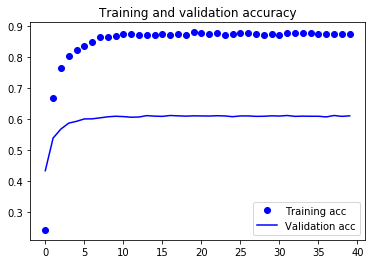

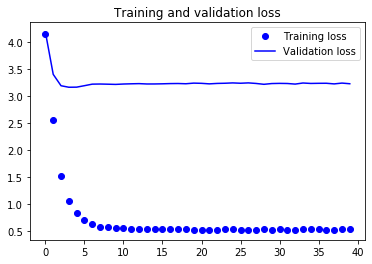

In [32]:
#Plot the training & validation loss & accuracy
import matplotlib.pyplot as plt

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, valid_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Save the model
PATH = './resnet50.pth'
torch.save(resnet50.state_dict(), PATH)

## Evaluation sur les données test


In [0]:
test_data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

In [35]:
image_datasets = datasets.ImageFolder('redim_download/test',
                                          test_data_transforms['test'])

RuntimeError: ignored

In [0]:
testloader = torch.utils.data.DataLoader(image_datasets, batch_size=32,
                                             shuffle=False, num_workers=0) 

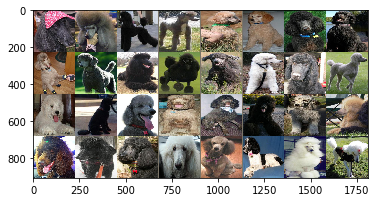

GroundTruth:  tensor(0) tensor(0) tensor(0) tensor(0)


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
# How the model perform on the whole dataset ?
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # Convert to CUDA tesnsor
        images, labels = data[0].to(device), data[1].to(device) 
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %
